# Estimating the marginal likelihood of a computational model with SMC

In [1]:
%load_ext autoreload
%autoreload 2

import os

# For JAX, we can use CPU (set SELECTED_DEVICE to empty (''), or one of the available GPUs)
SELECTED_DEVICE = '3'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [3]


In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrnd
import distrax as dx
import time
import pandas as pd
import requests
import pyreadr as pr
from tqdm import tqdm

jax.config.update("jax_enable_x64", True)  # important for log marginal likelihoods

from typing import Callable, Dict
from jaxtyping import Float, Array

# Set this to the directory of your clone of https://github.com/UncertaintyInComplexSystems/bayesianmodels
PATH_TO_UICSMODELS = '~/Documents/Repos/bayesianmodels'

import sys
sys.path.append(os.path.expanduser(PATH_TO_UICSMODELS))
from uicsmodels.bayesianmodels import BayesianModel, GibbsState

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from jax.random import PRNGKey
from pathlib import Path
from blackjax import rmh
from blackjax.diagnostics import potential_scale_reduction

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

key = jrnd.PRNGKey(42)

## The expectancy-valence model and its hierarchical extension

In [4]:
class ExpectancyValence(BayesianModel):

    def __init__(self, 
                 choices: Array, 
                 loss: Array, 
                 wins: Array,
                 priors: Dict,
                 K: int = 4):
        self.choices = choices
        self.loss = loss
        self.wins = wins
        self.param_priors = priors
        self.T = len(self.choices)
        self.K = K

    #
    def loglikelihood_fn(self) -> Callable:

        def loglikelihood_fn_(state: GibbsState) -> Float:
            position = getattr(state, 'position', state)
            w = position['w']
            a = position['a']
            c = 4*position['c_raw'] - 2.0
            ev = jnp.zeros((self.K, ))  # expected valence per deck of cards
            loglik = dx.Categorical(probs=jnp.ones((self.K, ))).log_prob(value=self.choices[0])

            def for_body(t, carry):
                ev_, loglik_ = carry
                theta = (0.1*(t+1))**c  
                current_utility = (1-w) * self.wins[t] + w*self.loss[t]
                ev_ = ev_.at[self.choices[t]].add(a * (current_utility - ev_[self.choices[t]]))
                loglik_ += dx.Categorical(logits=theta * ev_).log_prob(value=self.choices[t+1])
                return (ev_, loglik_)
            
            _, loglik = jax.lax.fori_loop(0, self.T - 1, for_body, (ev, loglik))
            
            return loglik
        
        #
        return loglikelihood_fn_

    #

#
class HierarchicalExpectancyValence(BayesianModel):

    def __init__(self, 
                 choices: Array, 
                 loss: Array, 
                 wins: Array,
                 priors: Dict,
                 K: int = 4):
        self.choices = choices
        self.loss = loss
        self.wins = wins
        self.param_priors = priors
        if jnp.ndim(self.choices) != 2:
            raise ValueError(f'Expected `choices` to be of size (N, T),',
                             f'but found {self.choices.shape} instead.')
        self.N, self.T = self.choices.shape
        self.K = K

    #
    def init_fn(self, key: PRNGKey, num_particles=1):
        """Because this model has hierarchical structure, we must specify how we initialize the particles by sampling from the prior.

        This proceeds by first sampling from the hyperpriors, and given the assigned values we sample w, a, and c_raw
        
        
        """
        key, subkey = jrnd.split(key)
        initial_position = super().init_fn(subkey, num_particles=num_particles).position

        for var in ['w', 'a', 'c_raw']:
            key, subkey = jrnd.split(key)
            initial_position[var] = dx.Transformed(dx.Normal(loc=initial_position[f'mu_{var}'],
                                                             scale=initial_position[f'sigma_{var}']),
                                                   tfb.NormalCDF()).sample(seed=subkey, sample_shape=(self.N, ))
            if num_particles > 1:
                initial_position[var] = jnp.transpose(initial_position[var], [1, 0])
        return GibbsState(position=initial_position)
    
    #
    def loglikelihood_fn(self) -> Callable:

        def loglikelihood_fn_(state: GibbsState) -> Float:
            def forward(logit_next_, choice_):
                return dx.Categorical(logits=logit_next_).log_prob(value=choice_)

            #
            position = getattr(state, 'position', state)
            w = position['w']
            a = position['a']
            c = 4*position['c_raw'] - 2.0
            ev = jnp.zeros((self.N, self.K))  # expected valence per deck of cards          
            loglik = jnp.sum(jax.vmap(forward, in_axes=(0, 0))(jnp.ones((self.N, self.K)), self.choices[:, 0]))
            row_inds = jnp.arange(self.N)

            def for_body(t, carry):
                ev_, loglik_ = carry
                theta = (0.1*(t+1))**c  
                current_utility = (1-w) * self.wins[:, t] + w*self.loss[:, t]
                ev_ = ev_.at[row_inds, self.choices[:, t]].add(a * (current_utility - ev_.at[row_inds, self.choices[:, t]].get()))
                loglik_ += jnp.sum(jax.vmap(forward, in_axes=(0, 0))(theta[:, jnp.newaxis] * ev_, self.choices[:, t+1]))
                return (ev_, loglik_)
            
            _, loglik = jax.lax.fori_loop(0, self.T - 1, for_body, (ev, loglik))
            return loglik
        
        #
        return loglikelihood_fn_
    
    #
    def logprior_fn(self) -> Callable:
        """Similar to the initialization, we must specify the log prior density. This is simply the logdensity of each of the hyperparameters, plus the logdensity of the lower-level parameters.
        
        """

        def logprior_fn_(state: GibbsState) -> Float:
            position = getattr(state, 'position', state)            
            logprob = 0.0
            for var in ['w', 'a', 'c_raw']:
                logprob += self.param_priors[f'mu_{var}'].log_prob(value=position[f'mu_{var}'])
                logprob += self.param_priors[f'sigma_{var}'].log_prob(value=position[f'sigma_{var}'])
                hier_dist = dx.Transformed(dx.Normal(loc=position[f'mu_{var}'],
                                                     scale=position[f'sigma_{var}']), tfb.NormalCDF())
                
                logprob += jnp.sum(hier_dist.log_prob(value=position[var]))

            return logprob
        
        #
        return logprior_fn_
    
    #
#

The data for this experiment are available on the Open Science Framework, in the repository by Steingroever et al.: https://osf.io/f9cq4/. Below, we download these data.


In [4]:
def download_to_disk(url, filepath):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filepath, 'wb') as file:
            file.write(response.content)
        print('File downloaded successfully!')
    else:
        print(f'Failed to download the file. Status code: {response.status_code}')

#
data_busemeyer_url = 'https://osf.io/download/5vws6/'  # DataBusemeyerNoNA.rdata on https://osf.io/f9cq4/; contains IGT data
data_busemeyer_file = '../Data/DataBusemeyerNoNA.rdata'

data_steingroever_url = 'https://osf.io/download/bmnsv/'  # contains Steingroever's importance sampling marginal likelihoods
data_steingroever_file = '../Data/DataSteingroever.rdata'

lml_url = 'https://osf.io/download/txnbs/' # ind_LogMargLik.txt on https://osf.io/f9cq4/; contains Gronau's bridge sampling estmates
lml_file = '../Data/ind_LogMargLik.txt'

download_to_disk(data_busemeyer_url, data_busemeyer_file)
download_to_disk(data_steingroever_url, data_steingroever_file)
download_to_disk(lml_url, lml_file)

File downloaded successfully!
File downloaded successfully!
File downloaded successfully!


Read IGT data

In [6]:
data_file = pr.read_r(os.path.join(Path(os.getcwd()).parents[0], 'Data/DataBusemeyerNoNA.rdata'))
choices = jnp.asarray(data_file['choice'].to_numpy().astype(int)) - 1  # Python zero-indexing
losses = jnp.asarray(data_file['lo'].to_numpy())
wins = jnp.asarray(data_file['wi'].to_numpy())

N, T = choices.shape

First, we compute the log marginal likelihoods for the individual participants, using the standard Expectancy-Valence model (this takes about 6 minutes):

In [5]:
priors = dict(w=dx.Beta(alpha=1.0, beta=1.0),
              a=dx.Beta(alpha=1.0, beta=1.0),
              c_raw=dx.Beta(alpha=1.0, beta=1.0))

lmls = jnp.zeros((N, ))

rmh_parameters = dict(sigma=0.01*jnp.eye(3))  
smc_parameters = dict(kernel=rmh,
                    kernel_parameters=rmh_parameters,
                    num_particles=1_000,
                    num_mcmc_steps=100)

for subj in range(N):
    key, subkey = jrnd.split(key)
    EVModel = ExpectancyValence(choices[subj, :], losses[subj, :], wins[subj, :], priors)           
    particles, num_adapt, lml = EVModel.inference(subkey, mode='mcmc-in-smc', sampling_parameters=smc_parameters)

    results = dict()
    results['samples'] = EVModel.get_monte_carlo_samples(mode='smc')
    results['key'] = subkey
    results['num_adapt'] = num_adapt
    results['lml'] = lml
    lmls = lmls.at[subj].set(lml) 

Compare with bridge sampling in Gronau et al. (2017):

Correlation between SMC and Importance sampling is 1.000
Correlation between SMC and Bridge sampling is 1.000


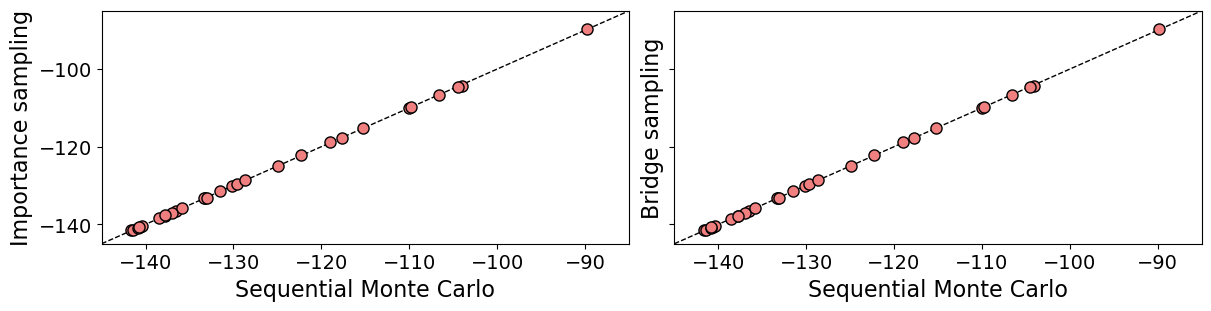

In [35]:
lims = [-145, -85]
bs_lmls_file = open(f'../Data/ind_LogMargLik.txt')
lines = bs_lmls_file.readlines()
bs_lmls = jnp.array([float(line.split()[1]) for line in lines[1:]])

is_lmls_file = pr.read_r(os.path.join(Path(os.getcwd()).parents[0], 'Data/DataSteingroever.rdata'))
is_lmls = jnp.squeeze(jnp.log(pr.read_r(f'/scratch/big/home/maxhin/Documents/Code/SMC tutorial/EV/data/margLike_SteingroeverEtAl2016_importance_sampling.Rdata')['marg.like'].to_numpy()))

baselines = [is_lmls, bs_lmls]

baseline_names = ['Importance sampling', 'Bridge sampling']

_, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True, figsize=(12, 3))
for i, (baseline, name, ax) in enumerate(zip(baselines, baseline_names, axes)):
    print(f'Correlation between SMC and {name} is {jnp.corrcoef(lmls, baseline)[0, 1]:0.3f}')
    ax.scatter(lmls, baseline, c='lightcoral', edgecolors='k', s=64, zorder=10)
    ax.plot(lims, lims, ls='--', c='k', lw=1, zorder=5)
    ax.set_xlabel('Sequential Monte Carlo')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylabel(name)

The hierarchical model combines all subjects, and includes group-level parameters as well. This results in a 96-dimensional posterior, which is way harder to determine the marginal likelihood for. The code below performs this estimation, 10 times for each setting for the number of mutation steps, so we obtain an indication of the variability.

Note that, as described in the paper and the works cited therein, the number of mutation steps has a big impact on the log marginal likelihood estimate. For this model, we find that we need $M=10\cdot 2^{13}=81\,920$ mutation steps to rival the performance of the bridge sampling estimate, which takes roughly twice the time. Smarter proposals will probably help a great deal, but are not implemented at the moment (right now, the proposal covariance matrix is $\Sigma=\sigma I_p$, with $p$ variables in the model and $\sigma=0.01$).

In [ ]:
priors = dict(mu_w=dx.Normal(loc=0.0, scale=1.0),
              mu_a=dx.Normal(loc=0.0, scale=1.0),
              mu_c_raw=dx.Normal(loc=0.0, scale=1.0),
              sigma_w=dx.Uniform(low=0.0, high=1.5),
              sigma_a=dx.Uniform(low=0.0, high=1.5),
              sigma_c_raw=dx.Uniform(low=0.0, high=1.5))

HEVModel = HierarchicalExpectancyValence(choices, losses, wins, priors)

num_params = 3 * (N+2)  # 6 group-level and N x 3 individual-level parameters 
rmh_parameters = dict(sigma=0.01*jnp.eye(num_params))

# We perform multiple runs to obtain an estimate of the variance of the LML estimator
num_runs = 10

num_particles = 1000
num_steps = [10*2**k for k in jnp.arange(2, 13+1)]

for run in tqdm(range(num_runs)):   
    key = jrnd.PRNGKey(1234 * run) 

    for num_mcmc_steps in num_steps:
        key, subkey = jrnd.split(key)
        results_file = os.path.join(Path(os.getcwd()).parents[0], f'Results/hev_lml_{num_mcmc_steps}_steps_{run}.npy')
        if os.path.exists(results_file):
            print(f'{results_file} already exists')
        else:
            print(f'RUN {run:02d}\tNum particles: {num_particles}, num mutations: {num_mcmc_steps}')
            
            smc_parameters = dict(kernel=rmh,
                                    kernel_parameters=rmh_parameters,
                                    num_particles=num_particles,
                                    num_mcmc_steps=num_mcmc_steps)

            start = time.time()
            particles, num_adapt, lml = HEVModel.inference(subkey, mode='mcmc-in-smc', sampling_parameters=smc_parameters)
            elapsed = time.time() - start
            print(f"Time elapsed: {time.strftime('%Hh:%Mm:%Ss', time.gmtime(elapsed))}")

            results = dict()
            results['samples'] = HEVModel.get_monte_carlo_samples(mode='smc')
            results['key'] = key
            results['num_adapt'] = num_adapt
            results['num_particles'] = smc_parameters['num_particles']
            results['num_mcmc_steps'] = smc_parameters['num_mcmc_steps']
            results['lml'] = lml
            results['time'] = elapsed

            jnp.save(results_file, results)

            print(f'Log marginal likelihood hierarchical EV model: {lml}')
            print(f'Number of adaptation steps: {num_adapt}')

#

Aggregate the results for easier plotting.

In [18]:
aggregated_results_file = os.path.join(Path(os.getcwd()).parents[0], f'Results/hev_lml_aggregated.npz')

redo = True

S = len(num_steps)
num_particles = 1000

param = 'mu_a'

if os.path.exists(aggregated_results_file) and not redo:
    results = jnp.load(aggregated_results_file)
    aggregated_lml = results['aggregated_lml']
    aggregated_times = results['aggregated_times']
    samples_hierarchical = results['samples_hierarchical']
    R = results['R']
    CoV = results['CoV']
else:
    aggregated_lml = jnp.zeros((S, num_runs))
    aggregated_times = jnp.zeros((S, num_runs))
    samples_hierarchical = jnp.zeros((6, S, num_runs, 1000))
    R = jnp.zeros((S,))
    CoV = jnp.zeros((S,))

    for s, num_mcmc_steps in enumerate(num_steps):
        print(f'{num_mcmc_steps} mutation steps')
        aggregated_samples = jnp.zeros((num_runs, num_particles))   

        for run in range(num_runs):
            runfile = os.path.join(Path(os.getcwd()).parents[0], f'Results/hev_lml_{num_mcmc_steps}_steps_{run}.npy')
            if os.path.exists(runfile):
                results = jnp.load(runfile, allow_pickle=True).item()
                samples = results['samples']    
                aggregated_samples = aggregated_samples.at[run, :].set(samples[param])
                aggregated_lml = aggregated_lml.at[s, run].set(results['lml'])
                aggregated_times = aggregated_times.at[s, run].set(results['time'])
        
        print(f'Mean LML: {jnp.mean(aggregated_lml[s, :])}')
        psrf = potential_scale_reduction(aggregated_samples)
        cv = 100*jnp.std(aggregated_lml[s, :]) / jnp.abs(jnp.mean(aggregated_lml[s, :]))
        print(f'{num_particles} particles, {num_mcmc_steps} MCMC steps:')
        print(f'Gelman & Rubin\'s potential scale reduction factor: {psrf:.3f}')

        R = R.at[s].set(psrf)

    #            
    jnp.savez(aggregated_results_file, aggregated_lml=aggregated_lml, aggregated_times=aggregated_times, R=R)

160 mutation steps
Mean LML: -3829.740032835476
1000 particles, 160 MCMC steps:
Gelman & Rubin's potential scale reduction factor: 3.341
320 mutation steps
Mean LML: -3812.0549794555623
1000 particles, 320 MCMC steps:
Gelman & Rubin's potential scale reduction factor: 1.278
640 mutation steps
Mean LML: -3808.328409608087
1000 particles, 640 MCMC steps:
Gelman & Rubin's potential scale reduction factor: 1.209
1280 mutation steps
Mean LML: -3805.674011574928
1000 particles, 1280 MCMC steps:
Gelman & Rubin's potential scale reduction factor: 1.394
2560 mutation steps
Mean LML: -3804.6880907160566
1000 particles, 2560 MCMC steps:
Gelman & Rubin's potential scale reduction factor: 1.043
5120 mutation steps
Mean LML: -3803.579354113807
1000 particles, 5120 MCMC steps:
Gelman & Rubin's potential scale reduction factor: 1.068
10240 mutation steps
Mean LML: -3801.8152759683326
1000 particles, 10240 MCMC steps:
Gelman & Rubin's potential scale reduction factor: 1.015
20480 mutation steps
Mean LM

We see that the potential scale reduction factor (PSRF, a.k.a. $\hat{R}$) drops much faster than the quality of the log marginal likelihood estimate increases. Still, given enough samples, the SMC estimator approaches that of bridge sampling.

Plot the log marginal likelihood estimates as function of the number of mutation steps. For the bridge sampling estimate, an estimate of the estimator variance was obtained by repeating both the sampling process in JAGS as well as the bridge sampling in `R` 10 times (see Gronau et al., 2017).

BS estimate: -3800.5532857756684 (0.13613777248113032)


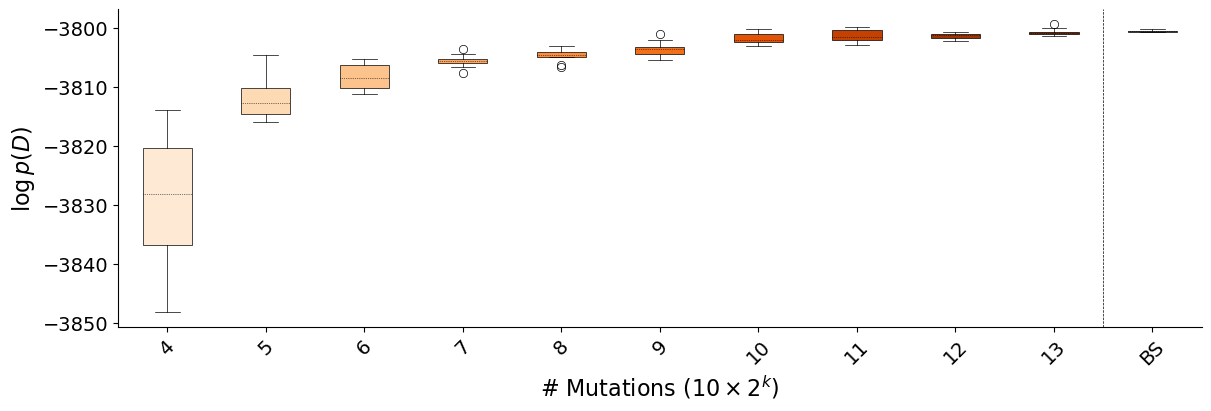

In [20]:
num_runs = 10
num_steps = [160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920]

S = len(num_steps)

bs_lml = jnp.squeeze(jnp.asarray(pd.read_csv(os.path.join(Path(os.getcwd()).parents[0], f'Results/collected_LML_{num_runs}_runs.csv')).values))

colors = plt.get_cmap('Oranges')(jnp.linspace(0.1, 1.0, S))

fig = plt.figure(constrained_layout=True, figsize=(12, 4))
ax_lml = plt.gca()
        
ax_lml.set_xlabel(r'# Mutations ($10\times 2^k$)')
ax_lml.set_ylabel(r'$\log p(D)$')
    
bp_smc = ax_lml.boxplot(aggregated_lml, patch_artist=True, labels=jnp.arange(4, 14))    
bp_bs = ax_lml.boxplot(bs_lml, patch_artist=True, positions=[S+1], labels=['BS'], widths=[0.5])
bp_bs['boxes'][0].set_facecolor('grey')

for patch, color in zip(bp_smc['boxes'], colors):
    patch.set_facecolor(color)

for bp in [bp_smc, bp_bs]:
    for median in bp['medians']:
        median.set_color('black')
        median.set_linestyle(':')
        median.set_linewidth(0.5)
    for whisker in bp['whiskers']:
        whisker.set_linewidth(0.5)
    for box in bp['boxes']:
        box.set_linewidth(0.5)
    for cap in bp['caps']:
        cap.set_linewidth(0.5)
    for flier in bp['fliers']:
        flier.set_markeredgewidth(0.5)

xticklabels = [*jnp.arange(4, 14), 'BS']
ax_lml.set_xticklabels(xticklabels, rotation = 45)
ax_lml.axvline(x=S+0.5, color='k', lw=0.5, ls='--')

for spine in ['top', 'right']:
    ax_lml.spines[spine].set_visible(False)
    
plt.show()